## Plot pressure-temperature vertical profiles

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator

In [3]:
from util_commons import PLANETS, SUITES
from util_mypaths import path_to_results
from util_plot_func import use_paper_style

In [4]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
use_paper_style()

In [5]:
# Parameters
metallicity = "solar"
t0 = 80  # 80th slice of 10-day-frequency output, i.e. 800 day
tgt_plevs = np.logspace(7, 2, 65)  # target pressure levels
tgt_lats = [0, 60]  # target latitudes
tgt_lons = np.arange(0, 360, 30) + 1.25  # target longitudes*
interp_args = ([("latitude", tgt_lats), ("longitude", tgt_lons)], iris.analysis.Linear())
# *in the UM v11.4 substellar point in radiation is shifted 1.25 degrees east

In [6]:
vrbls = {}
for planet in PLANETS.keys():
    vrbls[planet] = {}
    for exp in ["equilibrium", "kinetics"]:
        vrbls[planet][exp] = {}
        # Find initial pressure-temperature profiles created using ATMO
        init_pt_path = SUITES[planet][exp][metallicity]["initial_pt_profile_file"]
        init_pres_vp = iris.load_cube(str(init_pt_path), "pressure_si")
        init_temp_vp = iris.load_cube(str(init_pt_path), "temperature")
        # Select initial pressure-temperature profile data between 1e2-1e7 Pa
        pres_1e2_1e7 = np.where((init_pres_vp.data <= 1e7) & (init_pres_vp.data >= 1e2))
        init_pres_1e2_1e7 = init_pres_vp[pres_1e2_1e7]
        init_temp_1e2_1e7 = init_temp_vp[pres_1e2_1e7]
        # Find other data
        fpath = SUITES[planet][exp][metallicity]["dir_for_merged"]
        fname = f"{SUITES[planet][exp][metallicity]['suite']}.nc"
        # Load variables
        pres = iris.load_cube(str(fpath / fname), um.pres)[-1, ...]
        _temp = iris.load_cube(str(fpath / fname), um.temp)[t0:, ...]
        temp = _temp.collapsed("time", iris.analysis.MEAN)
        # Interpolate temperature to pressure levels
        temp_plevs = interp_cube_from_height_to_pressure_levels(temp, pres, tgt_plevs)
        temp_plevs_locs = temp_plevs.interpolate(*interp_args)
        pres_coord = temp_plevs_locs.coord("air_pressure")
        # Assemble data
        vrbls[planet][exp] = {
            "init_pres_1e2_1e7": init_pres_1e2_1e7,
            "init_temp_1e2_1e7": init_temp_1e2_1e7,
            "temp_plevs_locs": temp_plevs_locs,
        }

In [7]:
# Plotting parameters
# Sample each colormap 4 times but use the brightest 3 colours from each colormap
nclrs = 4
clrs_1 = plt.cm.Blues_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_2 = plt.cm.Oranges(np.linspace(0, 1, nclrs)[1:])
clrs_3 = plt.cm.Reds_r(np.linspace(0, 1, nclrs)[0 : nclrs - 1])
clrs_4 = plt.cm.Greens(np.linspace(0, 1, nclrs)[1:])
lon_clrs = np.concatenate([clrs_1, clrs_2, clrs_3, clrs_4])

alpha_60 = 0.4
lon_clrs_60 = lon_clrs * np.array([1, 1, 1, alpha_60])
leg_lat_kw = {
    "0": {"linestyle": "-", "linewidth": 2, "color": "grey"},
    "60°N": {"linestyle": "-", "linewidth": 1, "color": "grey", "alpha": alpha_60},
}

leg_exp_kw = {
    "Equilibrium": {"linestyle": "--", "linewidth": 2, "color": "k"},
    "Kinetics": {"linestyle": "-", "linewidth": 2, "color": "k"},
}
leg_line_kw = {"equilibrium": {"linestyle": "--"}, "kinetics": {"linestyle": "-"}}
leg_init_kw = {"Initial": {"linestyle": (0, (1, 1)), "linewidth": 2, "color": "k"}}

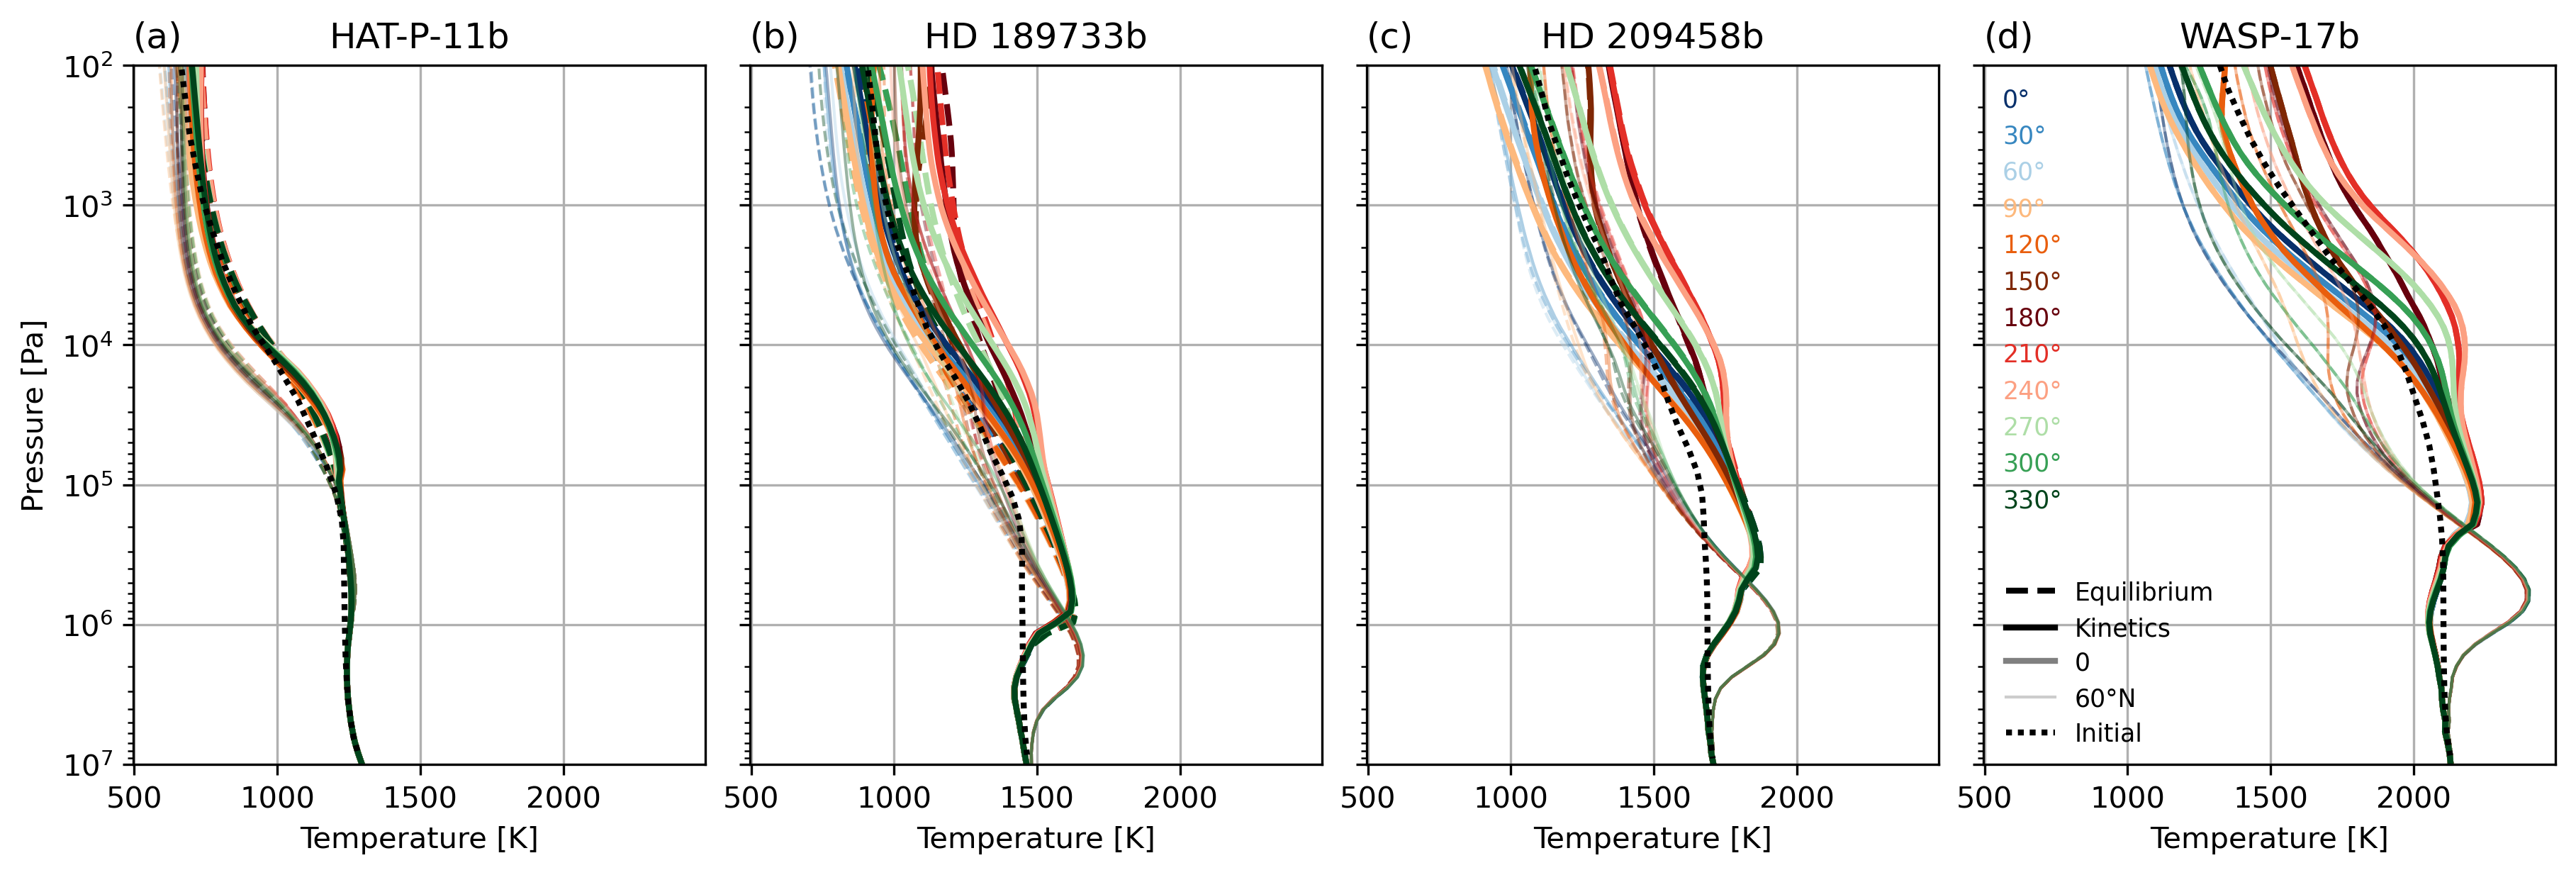

In [8]:
# Plot
fig, axes = plt.subplots(
    ncols=4,
    nrows=1,
    figsize=(12, 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
iletters = subplot_label_generator()
for planet, ax in zip(PLANETS.keys(), axes.flatten()):
    ax.set_title(f"({next(iletters)})", loc="left")
    ax.set_title(f'{PLANETS[planet]["tex"]}', loc="center")
    ax.set_xlabel(f"Temperature [K]")
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Pressure [Pa]")
    ax.set_yscale("log")
    ax.set_ylim(1e7, 1e2)
    ax.grid()
    for exp, plt_kw in leg_line_kw.items():
        for lon, clr, clr60 in zip(tgt_lons, lon_clrs, lon_clrs_60):
            vp00 = vrbls[planet][exp]["temp_plevs_locs"].extract(
                iris.Constraint(latitude=0, longitude=lon)
            )
            vp60 = vrbls[planet][exp]["temp_plevs_locs"].extract(
                iris.Constraint(latitude=60, longitude=lon)
            )
            ax.plot(
                vp00.data,
                pres_coord.points,
                **plt_kw,
                color=clr,
                label=f"{int(lon-1.25)}°",
                linewidth=2,
            )
            ax.plot(
                vp60.data,
                pres_coord.points,
                **plt_kw,
                color=clr60,
                label=f"{int(lon-1.25)}°",
                linewidth=1,
            )
    # Add initial pressure-temperature profiles
    init_pres = vrbls[planet][exp]["init_pres_1e2_1e7"]
    init_temp = vrbls[planet][exp]["init_temp_1e2_1e7"]
    ax.plot(init_temp.data, init_pres.data, color="k", linewidth=2, linestyle=(0, (1, 1)))
# Add extra legends
add_custom_legend(
    ax, leg_exp_kw, loc="center left", bbox_to_anchor=(0, 0.22), frameon=False, fontsize="small"
)
add_custom_legend(
    ax, leg_lat_kw, loc="center left", bbox_to_anchor=(0, 0.12), frameon=False, fontsize="small"
)
add_custom_legend(
    ax, leg_init_kw, loc="lower left", bbox_to_anchor=(0, -0.005), frameon=False, fontsize="small"
)
# Add longitudes legend
# Delete repeating handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
i = 1
while i < len(labels):
    if labels[i] in labels[:i]:
        del labels[i]
        del handles[i]
    else:
        i += 1
leg = ax.legend(
    handles,
    labels,
    loc="upper left",
    bbox_to_anchor=(-0.04, 1),
    frameon=False,
    handlelength=0,
    fontsize="small",
)
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
# Save
fig.savefig(path_to_results / "vps" / f"pres_temp_vp_xaxis_same_w_grid.png")  # _w_grid